In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)
import sys
from tqdm import tqdm

#insert path
sys.path.insert(0, '../methods/')

sys.modules.pop('ARWME', None)
from ARWME import *

In [5]:
# ELEC2 data set
# downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv('electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

# weights and tags (parameters for new methods)
rho = 0.99; rho_LS = 0.99

In [35]:
# split conformal prediction with least squares
def splitCP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    
    # odd data points for training, even for calibration
    inds_odd = np.arange(1,int(np.ceil(n/2)*2-1),2)
    inds_even = np.arange(2,int(np.floor(n/2)*2),2)

    # train model
    betahat = np.linalg.solve(X[inds_odd].T.dot(X[inds_odd]),  X[inds_odd].T.dot(Y[inds_odd]))
    
    # compute residual quantile on calibration set
    weights_calib = weights[inds_even] / (np.sum(weights[inds_even])+weights[-1])

    if(np.sum(weights_calib) >= 1-alpha):
        R = np.abs(Y[inds_even] - X[inds_even].dot(betahat))
        ord_R = np.argsort(R)
        ind_thresh = np.min(np.where(np.cumsum(weights_calib[ord_R])>=1-alpha))
        calib_thresh = np.sort(R)[ind_thresh]
    else:
        calib_thresh = np.inf
    
    y_PI = np.array([x.T.dot(betahat)-calib_thresh,x.T.dot(betahat)+calib_thresh])
    return y_PI


In [31]:
num_periods = 1000
N = num_periods

beta_1 = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5
#beta_1 = np.ones(num_periods)
#beta_1 = generate_true_means(num_periods-1, 2)
beta_2 = np.ones(num_periods)
#plt.plot(beta_1)
#plt.show()
beta = np.column_stack((beta_1, beta_2))
variance_y = 1; meanX = 1

np.random.seed(23)

#B_arr is for val set
B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

X, Y = generate_linreg_data(meanX, B_arr, beta, variance_y)


In [9]:
def generate_multinomial_X(meanX, dimX, N):
    return np.random.multivariate_normal(meanX*np.ones(dimX), np.eye(dimX), N)

def generate_linreg_data(meanX, B_arr, beta, variance):

    dimX = beta.shape[1]
    num_periods = len(B_arr)
    B_arr_starts = np.cumsum(B_arr) - B_arr
    B_arr_ends = np.cumsum(B_arr) - 1

    X = generate_multinomial_X(meanX, dimX, sum(B_arr))

    mu_y = np.zeros(len(X))

    for t in range(num_periods):
        X_t = X[B_arr_starts[t]:B_arr_ends[t]+1]
        mu_y[B_arr_starts[t]:B_arr_ends[t]+1] = X_t @ beta[t].T

    y = mu_y + np.random.normal(0, np.sqrt(variance), len(mu_y))

    return X, y

In [32]:
# run all methods

PI_CP_LS = np.zeros((N,2))
PI_CP_LS[:train_lag,0]=-np.inf; PI_CP_LS[:train_lag,1]=np.inf
PI_split_nexCP_LS = np.copy(PI_CP_LS)

#for n in tqdm(np.arange(train_lag, N)):
for n in tqdm(np.arange(train_lag, N)):

    #predict for the n^th period using the past n-1 periods
    weights=rho**(np.arange(n,0,-1))
    PI_split_nexCP_LS[n,:] = splitCP_LS(X[:n,:],Y[:n],X[n,:],alpha,weights=weights)
    

100%|██████████| 900/900 [00:00<00:00, 10046.53it/s]


In [34]:
widths= np.mean(PI_split_nexCP_LS[train_lag:,1]-PI_split_nexCP_LS[train_lag:,0]).mean()
#print(widths)
cov_split_nexCP_LS = (PI_split_nexCP_LS[train_lag:,0]<=Y[train_lag:]) * (PI_split_nexCP_LS[train_lag:,1]>=Y[train_lag:])

In [7]:
cov = cov_split_nexCP_LS.astype(int)

B_arr = np.ones(len(cov)).astype(int)
smoothed_cov = np.zeros(len(cov))
for t in tqdm(range(len(cov))):
    khat, s = ARWME(cov[:t+1], B_arr[:t+1], delta = 0.1, M = 1)
    smoothed_cov[t] = s
#plt.plot(smoothed_cov)

100%|██████████| 3344/3344 [00:51<00:00, 64.61it/s] 


0.028182821345744336


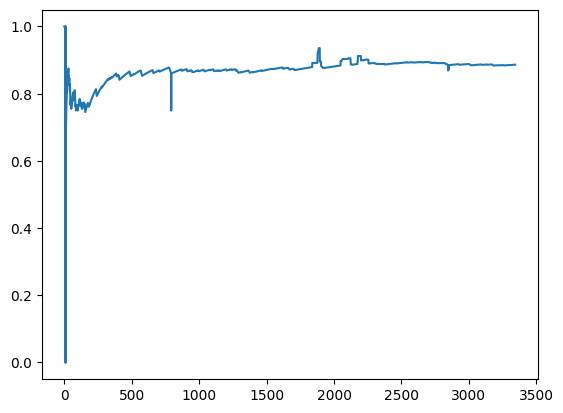

In [10]:
plt.plot(smoothed_cov)
mae = np.mean(np.abs(smoothed_cov - (1-alpha))[100:])
print(mae)

In [ ]:
# generate synthetic data

# parameters for all settings
np.random.seed(12345)
alpha = 0.1
N = 2000
p = 4
train_lag = 100 # start predicting after train_lag many observations
ntrial = 200
rho = 0.99; rho_LS = 0.99

X = np.random.normal(size=(ntrial,N,p))
Y = np.zeros((3,ntrial,N))
noise = np.random.normal(size=(ntrial,N))

# setting 1: i.i.d. data
beta_1 = np.array([2,1,0,0])
Y[0] = X.dot(beta_1) + noise

# setting 2: changepoints
changepoints = np.r_[500,1500]
n_changepoint = 2
beta_2 = np.array([[2,1,0,0],[0,-2,-1,0],[0,0,2,1]])
for i in np.arange(1+n_changepoint):
    if(i==0):
        ind_min = 0
    else:
        ind_min = changepoints[i-1]
    if(i==n_changepoint):
        ind_max = N
    else:
        ind_max = changepoints[i]
    Y[1,:,ind_min:ind_max] = X[:,ind_min:ind_max].dot(beta_2[i])\
        + noise[:,ind_min:ind_max]

# setting 3: distribution drift
beta_start = np.array([2,1,0,0])
beta_end = np.array([0,0,2,1])
beta_3 = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)
for i in np.arange(N):
    Y[2,:,i] = X[:,i].dot(beta_3[i])+noise[:,i]

setting_names = ['Setting 1 (i.i.d. data)',\
                     'Setting 2 (changepoints)','Setting 3 (distribution drift)']

In [ ]:
#plt.rcParams.update({'font.size': 14})

#window = 10 # will display a rolling average

#def rolling_avg(x,window):
#    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    
#for setting in np.arange(3):
#    plt.plot(np.arange(train_lag+window,N),\
#             rolling_avg(np.mean(cov_CP_LS[setting],0),window))
#    plt.plot(np.arange(train_lag+window,N),\
#             rolling_avg(np.mean(cov_nexCP_LS[setting],0),window))
#    plt.plot(np.arange(train_lag+window,N),\
#             rolling_avg(np.mean(cov_nexCP_WLS[setting],0),window))
#    plt.hlines(1-alpha,xmin=train_lag,xmax=N,linestyles='--',colors='gray')
#    if(setting == 1):
#        for i in np.arange(n_changepoint):
#            plt.vlines(changepoints[i],ymin=0,ymax=1,linestyles=':',colors='gray')
#    plt.legend(['CP-LS','nexCP+LS','nexCP+WLS'])
#    plt.title(setting_names[setting])
#    plt.ylabel('Coverage')
#    plt.xlabel('Time')
#    plt.ylim([0,1])
#    setting_ = setting+1
#    plt.savefig(('results_supplement/simulation_coverage_setting%d.png' %setting_),\
#                dpi=400,bbox_inches='tight')
#    plt.show()

In [ ]:
# plt.rcParams.update({'font.size': 14})
# for setting in np.arange(3):
#    plt.plot(np.arange(train_lag,N),np.mean(PI_width_CP_LS[setting],0))
#    plt.plot(np.arange(train_lag,N),np.mean(PI_width_nexCP_LS[setting],0))
#    plt.plot(np.arange(train_lag,N),np.mean(PI_width_nexCP_WLS[setting],0))
#    ymax = np.max(np.r_[np.mean(PI_width_CP_LS[setting],0).max(),\
#        np.mean(PI_width_nexCP_LS[setting],0).max(),\
#            np.mean(PI_width_nexCP_WLS[setting],0).max()])*1.1
#    if(setting == 1):
#        for i in np.arange(n_changepoint):
#            plt.vlines(changepoints[i],ymin=0,ymax=ymax,linestyles=':',colors='gray')
#    plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
#    plt.title(setting_names[setting])
#    plt.ylabel('Prediction interval width')
#    plt.xlabel('Time')
#    plt.ylim([0,ymax])
#    setting_ = setting+1
#    plt.savefig(('results_supplement/simulation_PI_width_setting%d.png' %setting_),\
#                dpi=400,bbox_inches='tight')
#    plt.show()


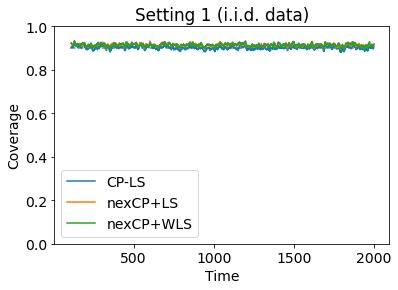

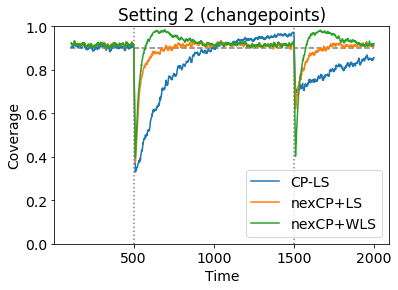

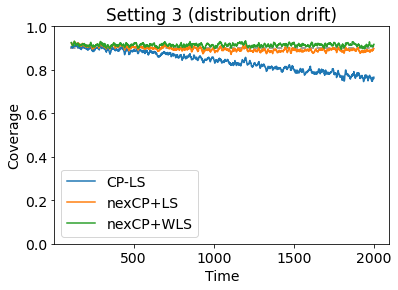

In [ ]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    
for setting in np.arange(3):
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_split_CP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_split_nexCP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_split_nexCP_WLS[setting],0),window))
    plt.hlines(1-alpha,xmin=train_lag,xmax=N,linestyles='--',colors='gray')
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=1,linestyles=':',colors='gray')
    plt.legend(['CP-LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Coverage')
    plt.xlabel('Time')
    plt.ylim([0,1])
    setting_ = setting+1
    plt.savefig(('results_supplement/simulation_coverage_splitCP_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()

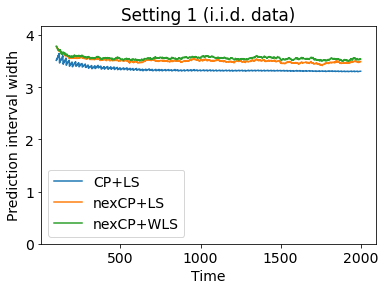

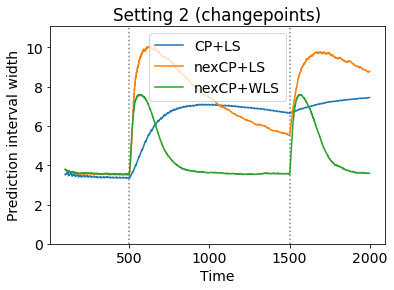

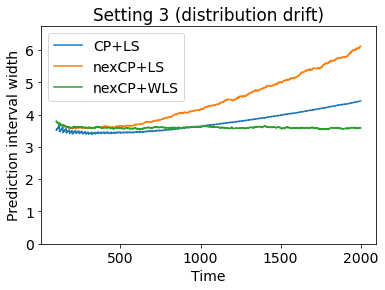

In [ ]:
plt.rcParams.update({'font.size': 14})
for setting in np.arange(3):
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_split_CP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_split_nexCP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_split_nexCP_WLS[setting],0))
    ymax = np.max(np.r_[np.mean(PI_width_split_CP_LS[setting],0).max(),\
        np.mean(PI_width_split_nexCP_LS[setting],0).max(),\
            np.mean(PI_width_split_nexCP_WLS[setting],0).max()])*1.1
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=ymax,linestyles=':',colors='gray')
    plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Prediction interval width')
    plt.xlabel('Time')
    plt.ylim([0,ymax])
    setting_ = setting+1
    plt.savefig(('results_supplement/simulation_PI_width_splitCP_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()


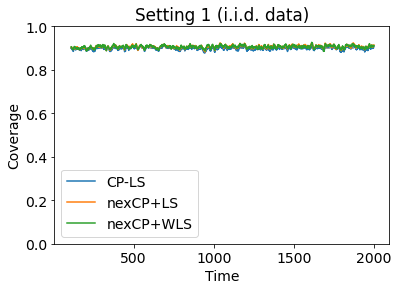

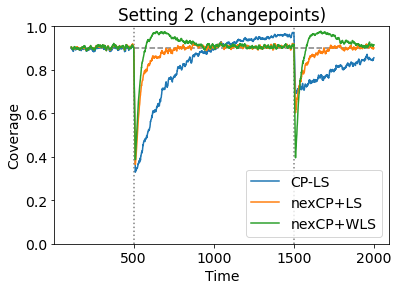

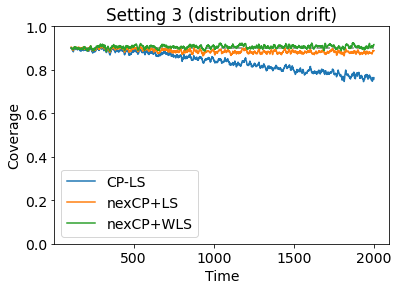

In [ ]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    
for setting in np.arange(3):
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_jack_CP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_jack_nexCP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_jack_nexCP_WLS[setting],0),window))
    plt.hlines(1-alpha,xmin=train_lag,xmax=N,linestyles='--',colors='gray')
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=1,linestyles=':',colors='gray')
    plt.legend(['CP-LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Coverage')
    plt.xlabel('Time')
    plt.ylim([0,1])
    setting_ = setting+1
    plt.savefig(('results_supplement/simulation_coverage_jack+_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()

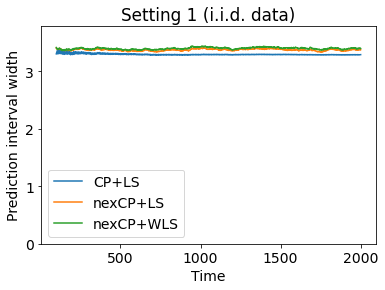

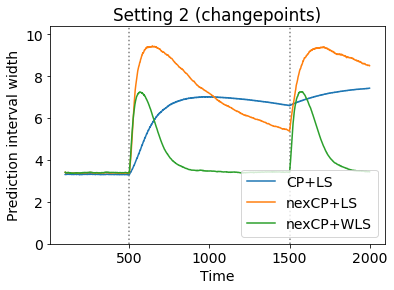

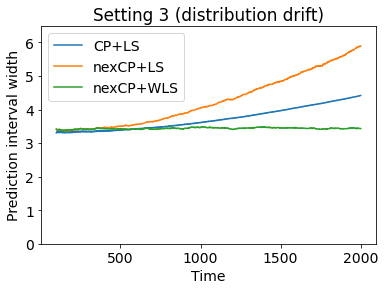

In [ ]:
plt.rcParams.update({'font.size': 14})
for setting in np.arange(3):
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_jack_CP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_jack_nexCP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_jack_nexCP_WLS[setting],0))
    ymax = np.max(np.r_[np.mean(PI_width_jack_CP_LS[setting],0).max(),\
        np.mean(PI_width_jack_nexCP_LS[setting],0).max(),\
            np.mean(PI_width_jack_nexCP_WLS[setting],0).max()])*1.1
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=ymax,linestyles=':',colors='gray')
    plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Prediction interval width')
    plt.xlabel('Time')
    plt.ylim([0,ymax])
    setting_ = setting+1
    plt.savefig(('results_supplement/simulation_PI_width_jack+_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()
